In [181]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from os import PathLike
from kalman_reconstruction.custom_plot import (
    set_custom_rcParams,
    plot_colors,
    plot_state_with_probability,
    adjust_lightness,
    ncols_nrows_from_N,
)
from kalman_reconstruction import pipeline
from kalman_reconstruction.statistics import normalize, crosscorr_ds_da
from reconstruct_climate_indices.statistics import xarray_dataset_welch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure

# from sklearn.linear_model import LinearRegression
from typing import Dict
import yaml

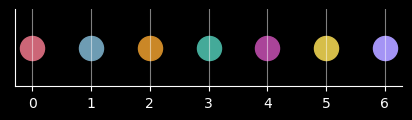

In [182]:
# ## LIGHT THEME
# plt.style.use("seaborn-v0_8-whitegrid")
# dark_color = [0.3, 0.3, 0.3]
# light_color = [0.8, 0.8, 0.8]
# lightness_0 = 0.75
# lightness_1 = 0.5
# cmap = "rocket"
# cmap_r = "rocket_r"

### DARK THEME
plt.style.use("dark_background")
dark_color = [0.7, 0.7, 0.7]
light_color = [0.2, 0.2, 0.2]
lightness_0 = 1.15
lightness_1 = 1.5
cmap = "rocket_r"
cmap_r = "rocket"


colors = set_custom_rcParams()
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["axes.grid"] = True

plot_colors(colors)

variables_color = dict()
variables_color["NAO_ST"] = colors[0]
variables_color["AMO"] = colors[1]
variables_color["AMO_roll_10y"] = colors[1]
variables_color["latent1"] = colors[2]
variables_color["latent2"] = colors[3]
variables_color["latent3"] = colors[4]
variables_color["log_likelihod"] = colors[-1]

In [183]:
RepoPath = Path(".").resolve().parent.parent

####################
### SET RUN NAME ###
####################
parent_run_name = "fearless-ram-101"

with open("nested_experiments.yaml", "r") as f:
    nested_experiments = yaml.safe_load(f)

run_names = nested_experiments[parent_run_name]["child_runs"]



results_path = RepoPath / Path("results") / "earth_system_models" / "CMIP6" / "Iterative" / parent_run_name
results_path.mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = True


def save_fig(fig: Figure, relative_path: PathLike, kwargs: Dict = dict()):
    store_path = results_path / relative_path
    store_path.parent.mkdir(parents=True, exist_ok=True)
    if SAVE_FIGURES:
        fig.savefig(store_path, **kwargs)
    else:
        pass

### load datasets

In [184]:
SubdataPath = "earth_system_models/processed/nested"
list_kalman_result = list()
list_state_variables = list()
list_kalman_states = list()

for run_name in run_names:
    RunPath = RepoPath / "data" / SubdataPath / run_name
    InputPath = RunPath / (run_name + "_input.nc")
    KalmanPath = RunPath / (run_name + "_kalman.nc")
    SettingsPath = RunPath / (run_name + "_setup.yaml")



    # Read YAML file
    with open(SettingsPath, "r") as stream:
        settings = yaml.safe_load(stream)


    kalman_input = xr.open_dataset(InputPath)
    kalman_result = xr.open_dataset(KalmanPath)
    kalman_states = pipeline.from_standard_dataset(ds=kalman_result)
    # kalman_input = kalman_input.rename(VAR_MAPPING)
    # kalman_states = kalman_states.rename(VAR_MAPPING)

    # display(kalman_states)
    model_name = settings["model_setup"]["model_name"]
    state_variables = list(kalman_states.data_vars.keys())
    state_variables[0], state_variables[1] = state_variables[1], state_variables[0]
    print(state_variables)
    list_kalman_result.append(kalman_result)
    list_kalman_states.append(kalman_states)
    list_state_variables.append(state_variables)

['NAO_ST', 'AMO', 'latent1']
['NAO_ST', 'AMO', 'latent1', 'latent2']
['NAO_ST', 'AMO', 'latent1', 'latent2', 'latent3']


In [185]:
list_latent_variables = [[key for key in list_state_variables[i] if "latent" in key] for i in range(len(list_state_variables))]
list_latent_variables

[['latent1'], ['latent1', 'latent2'], ['latent1', 'latent2', 'latent3']]

#### Plot Loglikelihood

In [186]:
# list_kalman_result_new = list()
# x_zero = 49
# for idx, data in enumerate(list_kalman_result):
#     data_new = data.copy()
#     data_new["kalman_iteration"] = data["kalman_iteration"] + idx * x_zero
#     list_kalman_result_new.append(data)

# # kalman_result = xr.concat(list_kalman_result_new, dim="kalman_iteration")

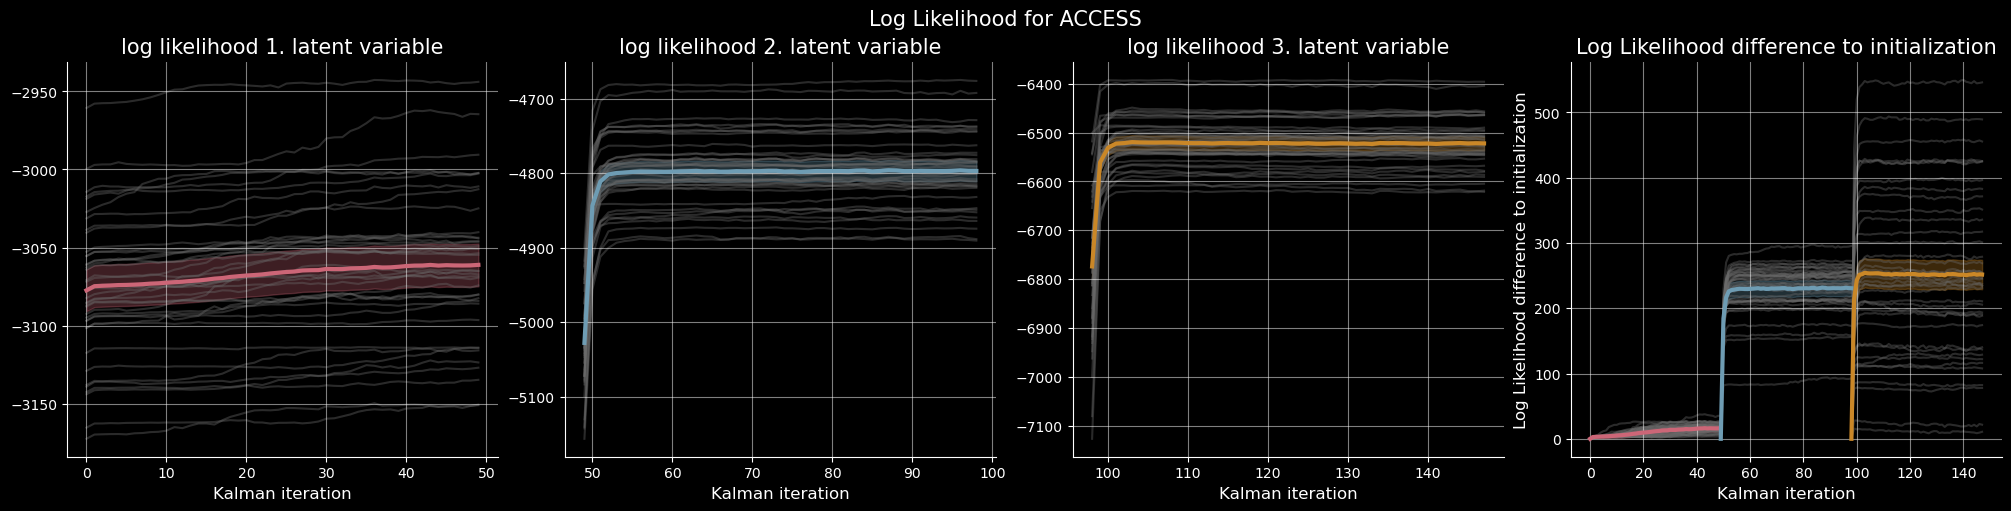

In [187]:
ncols = 1 + len(list_kalman_result)
fig, axs = plt.subplots(nrows=1, ncols=ncols, sharex=False, figsize=(20, 5), layout = "constrained")

var = "log_likelihod"#
x_zero = 0
for idx, data in enumerate(list_kalman_result):
    data = data[var]

    data_diff = data - data.isel(kalman_iteration=0)

    plot_state_with_probability(
        x_value=data["kalman_iteration"] + x_zero,
        state=data.mean(dim="member"),
        prob=data.std(dim="member"),
        stds=2,
        ax=axs[idx],
        line_kwargs=dict(linewidth=3, zorder=10, color = colors[idx]),
    )
    for mem in data.member:
        axs[idx].plot(
            data.kalman_iteration + x_zero,
            data.sel(member=mem),
            linestyle="-",
            color=adjust_lightness(dark_color, 0.6),
            alpha=0.4,
            zorder=1,
        )

    plot_state_with_probability(
        x_value=data_diff["kalman_iteration"] + x_zero,
        state=data_diff.mean(dim="member"),
        prob=data_diff.std(dim="member"),
        stds=2,
        ax=axs[-1],
        line_kwargs=dict(linewidth=3, zorder=10, color = colors[idx]),
    )
    for mem in data_diff.member:
        axs[-1].plot(
            data_diff.kalman_iteration + x_zero,
            data_diff.sel(member=mem),
            linestyle="-",
            color=adjust_lightness(dark_color, 0.6),
            alpha=0.4,
            zorder=1,
        )
        # axs[-1].annotate(
        #     f"{mem.values}",
        #     xy=(
        #         data_diff.kalman_iteration[-1],
        #         data_diff.sel(member=mem).isel(kalman_iteration=-1),
        #     ),
        # )
    x_zero += 49
for i in range(len(list_kalman_result))  :
    axs[i].set_title(f"log likelihood {i+1}. latent variable")
axs[-1].set_title("Log Likelihood difference to initialization")
axs[-1].set_ylabel("Log Likelihood difference to initialization")

for ax in axs.flatten():
    ax.set_xlabel("Kalman iteration")

fig.suptitle(f"Log Likelihood for {model_name}")
save_fig(fig, relative_path=f"{model_name}_Loglikelihood.svg")
save_fig(fig, relative_path=f"{model_name}_Loglikelihood.png", kwargs=dict(dpi=256))

# q What would be a

### NOTE:

It seems that 2 latent variables are sufficient

In [188]:
CHOOSEN_IDX = 1

In [189]:
kalman_states = list_kalman_states[CHOOSEN_IDX]
kalman_result = list_kalman_result[CHOOSEN_IDX]
state_variables = list_state_variables[CHOOSEN_IDX]
latent_variables = list_latent_variables[CHOOSEN_IDX]


### Analysis

#### Prepare Fourier analysis

**Note: The signal is not evenly spaced!**
**Imporovement needs to be done**

In [190]:
# # compute timesteps in days
dts = (
    kalman_input.time.shift(time=-1) - kalman_input.time.shift(time=0)
) / np.timedelta64(1, "D")
dt_mean = dts.mean()
fs = 365.25 / dt_mean
fs = fs.values

# fig, ax = plt.subplots(1, 1)
# dts.isel(time=slice(0, 5 * 12)).plot(
#     ax=ax,
#     linestyle="",
#     marker="o",
#     markersize="10",
# )
# ax.set_ylabel("Time-Step in days")
# ax.set_xlabel("Date")
# save_fig(fig, relative_path=f"{model_name}_Time-Step.png")
# save_fig(fig, relative_path=f"{model_name}_Time-Step.svg")
# # compute the mean timestep

In [191]:
welch_kwargs = dict(
    fs=fs,
    window="boxcar",
    nperseg=len(kalman_input.time),
)

kalman_input_freq = xarray_dataset_welch(
    ds=kalman_input,
    dim="time",
    welch_kwargs=welch_kwargs,
)
kalman_states_freq = xarray_dataset_welch(
    ds=kalman_states,
    dim="time",
    welch_kwargs=welch_kwargs,
)

#### Plot frequency analysis

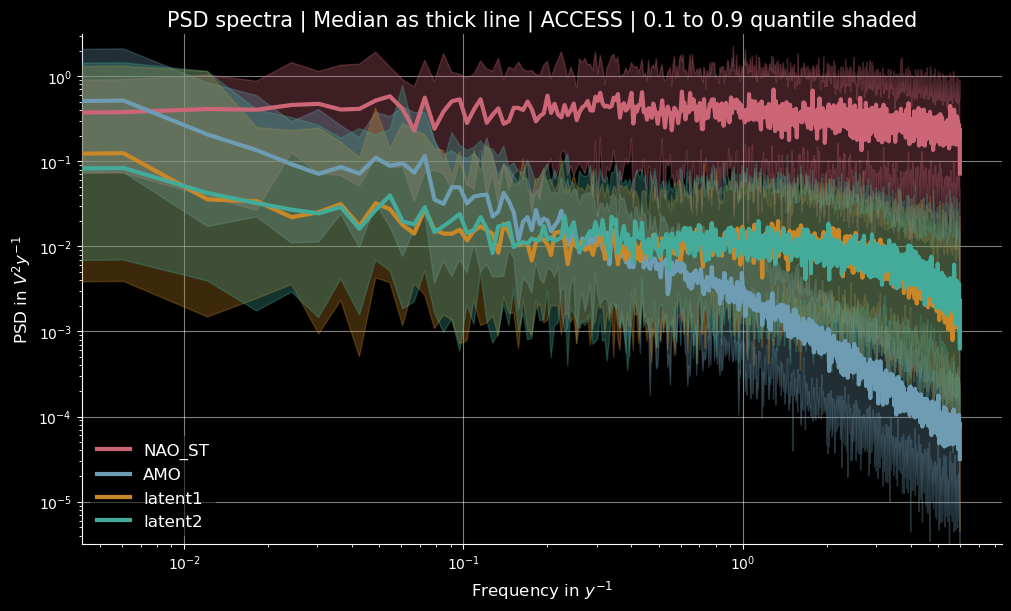

In [192]:
fig, axs = plt.subplots(
    nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10, 6), layout="constrained"
)
axs = np.array((axs,))

for var in state_variables:
    data = kalman_states_freq[var]
    # for mem in data.member :
    #     plt.loglog(data.frequency, data.sel(member = mem),
    #                linestyle = "-",
    #                color = [0.3,0.3,0.3],
    #                alpha = 0.1,
    #                zorder = 3)
    axs[0].loglog(
        data.frequency,
        data.median("member"),
        linestyle="-",
        color=variables_color[var],
        zorder=5,
        label=var,
        linewidth=3,
    )
    axs[0].fill_between(
        data.frequency,
        data.quantile(q=0.1, dim="member"),
        data.quantile(q=0.9, dim="member"),
        color=variables_color[var],
        alpha=0.3,
        zorder=3,
    )

axs[0].legend(loc="lower left")
axs[0].set_title(
    f"PSD spectra | Median as thick line | {model_name} | 0.1 to 0.9 quantile shaded"
)

for ax in axs.flatten():
    ax.set_ylim(ymin=10 ** (-5.5), ymax=10 ** (0.5))
    ax.set_ylabel(r"PSD in $V^2 y^{-1}$")
    ax.set_xlabel(r"Frequency in $y^{-1}$")

save_fig(fig, relative_path=f"{model_name}_PSD_spectra.svg")
save_fig(fig, relative_path=f"{model_name}_PSD_spectra.png", kwargs=dict(dpi=256))

#### Correlation of variables.

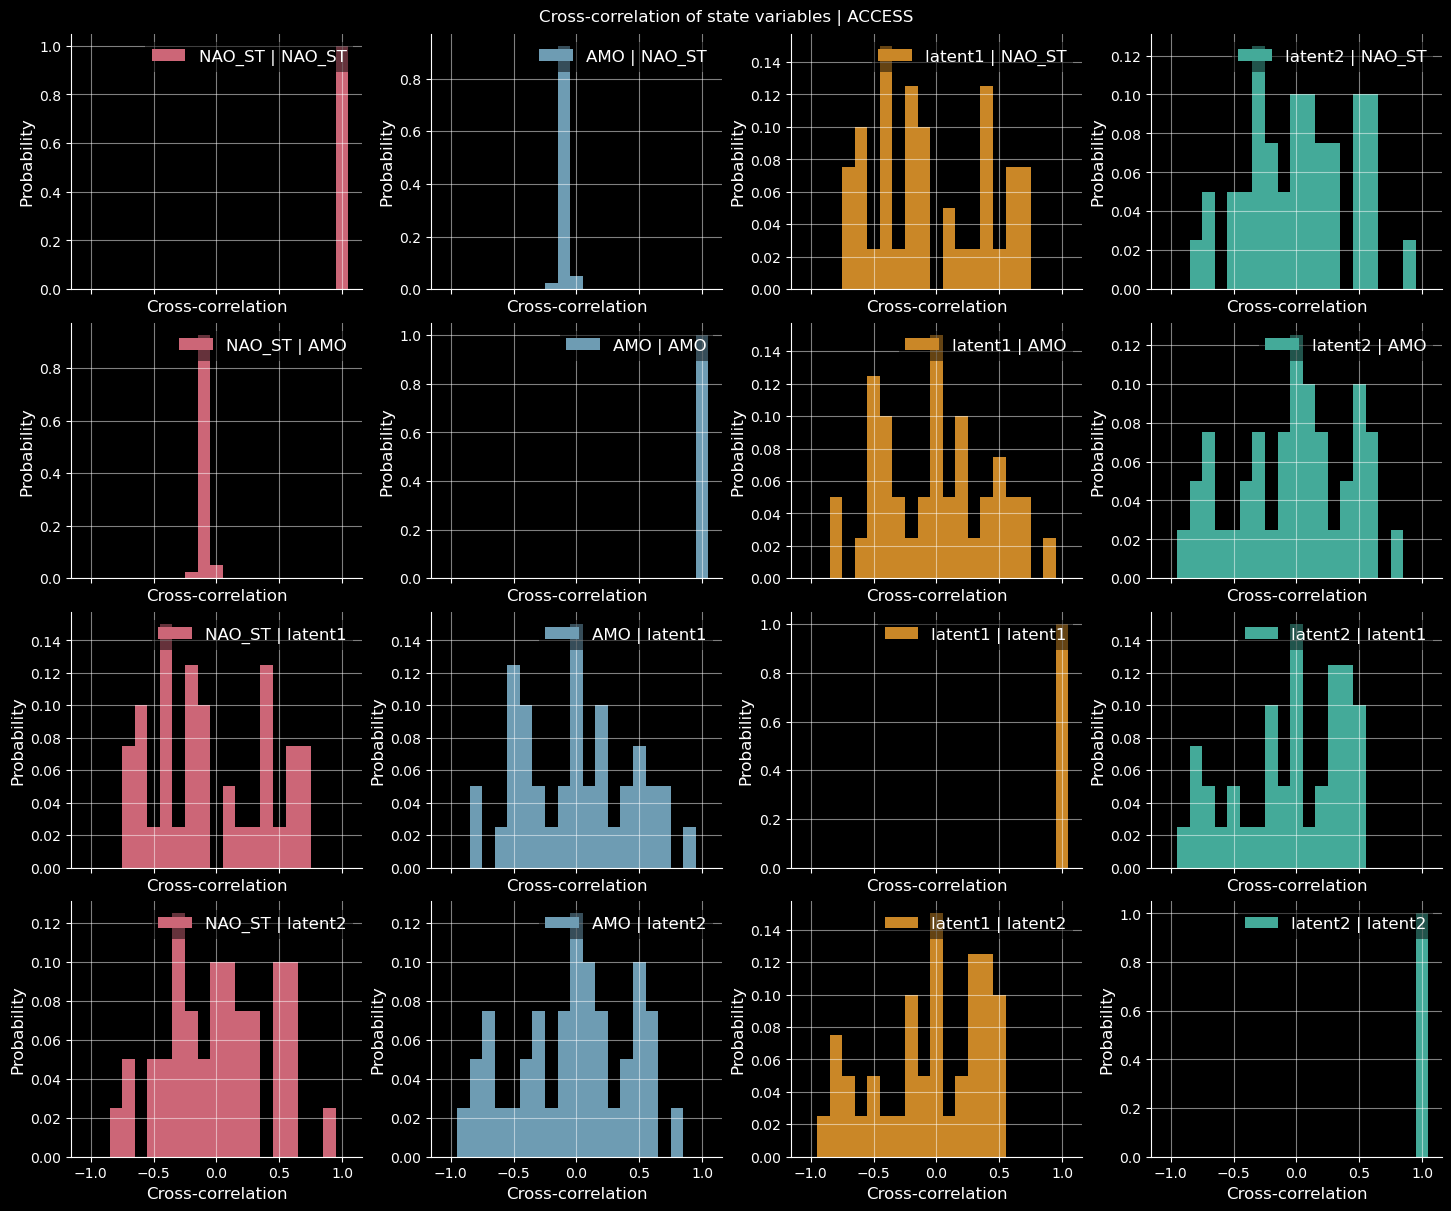

In [193]:
fig_width = 1.5 * 12 / 5 * len(state_variables)
fig_height = 1.5 * 2 * len(state_variables)
fig, axs = plt.subplots(
    nrows=len(state_variables),
    ncols=len(state_variables),
    sharex=True,
    sharey=False,
    figsize=(fig_width, fig_height),
    layout="constrained",
)

for i, correlation_var in enumerate(state_variables):

    corr_ds = crosscorr_ds_da(
        kalman_states, kalman_states[correlation_var], lag=0, dim="time"
    )
    dx = 0.1
    extent = 1
    bin_values = np.arange(-extent - dx, extent + dx, dx) + dx / 2
    x_values = (bin_values[:-1] + bin_values[1:]) / 2

    c, v = xr.apply_ufunc(
        np.histogram,
        corr_ds,  # Input frequencies
        input_core_dims=[
            ["member"],
        ],
        output_core_dims=[
            ["count"],
            ["edge"],
        ],
        vectorize=True,
        # dask='parallelized',
        # exclude_dims=set(("frequency",)),
        output_dtypes=[float, float],
        kwargs=dict(bins=bin_values, density=True),
    )

    c = c / c.sum()
    # c = normalize(c, dim="count", method="01")

    for j, var in enumerate(state_variables):
        axs[i, j].bar(
            x=x_values,
            height=c[var],
            width=dx,
            align="center",
            color=variables_color[var],
            linewidth=3,
            label=f"{var} | {correlation_var}",
        )
        axs[i, j].set_xlabel("Cross-correlation")
        axs[i, j].legend(loc="upper right")
        axs[i, j].set_ylabel("Probability")


fig.suptitle(f"Cross-correlation of state variables | {model_name}", size = 12)

save_fig(fig, relative_path=f"{model_name}_cross-correlation.svg")
save_fig(
    fig,
    relative_path=f"{model_name}_cross-correlation.png",
    kwargs=dict(dpi=256),
)

#### Evolution of latent variable

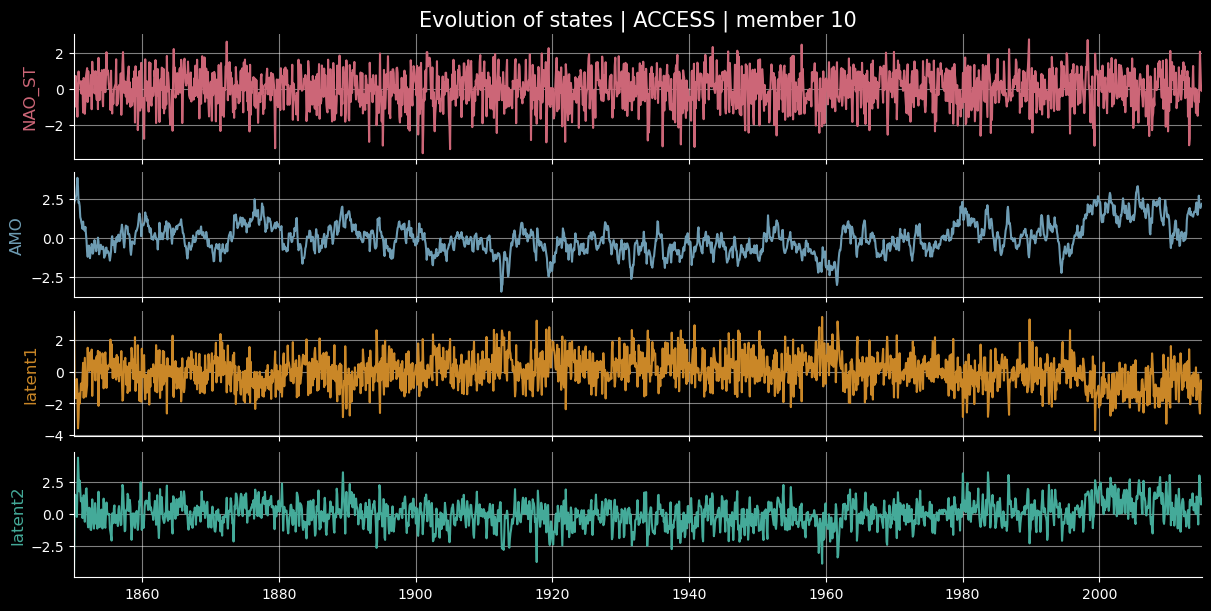

In [194]:
member = 10

height = int(6 / 4 * len(state_variables))
fig, axs = plt.subplots(
    nrows=len(state_variables),
    ncols=1,
    sharex=True,
    sharey=False,
    figsize=(12, height),
    layout="constrained",
)

current_ds = normalize(kalman_states.sel(member=member), method="mean", dim="time")
for idx, var in enumerate(state_variables):
    axs[idx].plot(
        current_ds.time, current_ds[var], label=var, color=variables_color[var]
    )
    axs[idx].set_ylabel(var, color=variables_color[var])

for ax in axs.flatten():
    ax.set_xlim(
        xmin=current_ds.time.min(),
        xmax=current_ds.time.max(),
    )

axs[0].set_title(f"Evolution of states | {model_name} | member {member}")
save_fig(fig, relative_path=f"{model_name}_Evolution_member_{member}.svg")
save_fig(
    fig,
    relative_path=f"{model_name}_Evolution_median_{member}.png",
    kwargs=dict(dpi=256),
)

### Perform smoothing of timeseries

In [195]:
# from scipy import fft

# def smooth_in_freq_space(x: np.ndarray, fft_dim: int = 0, smooth_dim: int = 1) -> np.ndarray:
#     """
#     Smooths an array along one dimension using median filtering in the frequency domain.

#     The function applies a median filter in the frequency domain to smooth the input array along the specified dimension.

#     Parameters:
#         x (np.ndarray): The input array to be smoothed.
#         fft_dim (int, optional): The dimension along which the FFT will be computed. Default is 1.
#         smooth_dim (int, optional): The dimension along which the smoothing will be applied. Default is 0.

#     Returns:
#         np.ndarray: The smoothed array.

#     Example:
#         # Smooth an array along the first dimension using median filtering in the frequency domain
#         >>> import numpy as np
#     """
#     if fft_dim >= smooth_dim:
#         res = fft.irfft(np.median(fft.rfft(x, axis=fft_dim), axis=smooth_dim), axis=fft_dim)
#     else :
#         res = fft.irfft(np.median((fft.rfft(x, axis=fft_dim)), axis=smooth_dim), axis=fft_dim)
#     return res

# smooth_kalman_states = xr.apply_ufunc(
#     smooth_in_freq_space,
#     kalman_states,
#     input_core_dims=[["time", "member"],],
#     output_core_dims=[["time"],],
#     vectorize=True,
#     output_dtypes=[float,],
# )

# smooth_kalman_states_freq = xarray_dataset_welch(
#     ds=smooth_kalman_states,
#     dim="time",
#     welch_kwargs=welch_kwargs,
# )

# plt.loglog(smooth_kalman_states_freq.AMO, label = "smoothed")
# plt.loglog(kalman_states_freq.AMO.median("member"), label = "median of members")
# plt.ylim(10 ** (-6.5), 10 ** (0.5))
# plt.legend()
# plt.title("AMO PSD spectra")

In [196]:
# height = int(6 / 4 * len(state_variables))
# fig, axs = plt.subplots(
#     nrows=len(state_variables),
#     ncols=1,
#     sharex=True,
#     sharey=False,
#     figsize=(12, height),
#     layout="constrained",
# )

# current_ds = normalize(smooth_kalman_states, method = "mean", dim = "time")
# for idx, var in enumerate(state_variables):
#     axs[idx].plot(
#         current_ds.time, current_ds[var], label=var, color=variables_color[var]
#     )
#     axs[idx].set_ylabel(var, color=variables_color[var])

# for ax in axs.flatten():
#     ax.set_xlim(
#         xmin=current_ds.time.min(),
#         xmax=current_ds.time.max(),
#     )

# axs[0].set_title(f"Evolution of states | {model_name} | Final state using frequency smoothed")

# save_fig(fig, relative_path=f"{model_name}_Evolution_smoothed.svg")
# save_fig(
#     fig,
#     relative_path=f"{model_name}_Evolution_smoothed.png",
#     kwargs=dict(dpi=256),
# )

#### Plot frequency analysis

In [197]:
# fig, ax = plt.subplots(
#     nrows=1, ncols=1, sharex=True, sharey=True, figsize=(12, 6), layout="constrained"
# )

# for var in state_variables:
#     data = smooth_kalman_states_freq[var]
#     ax.loglog(
#         data.frequency,
#         data,
#         linestyle="-",
#         color=variables_color[var],
#         zorder=5,
#         label=var,
#         linewidth=3,
#     )

# ax.legend(loc="lower left")

# ax.set_ylim(ymin=10 ** (-6.5), ymax=10 ** (0.5))
# ax.set_ylabel(r"PSD in $V^2 y^{-1}$")
# ax.set_xlabel(r"Frequency in $y^{-1}$")

# save_fig(fig, relative_path=f"{model_name}_PSD_spectra_smooth.svg")
# save_fig(fig, relative_path=f"{model_name}_PSD_spectra_smooth.png", kwargs=dict(dpi = 256))